Saving lupita-nyong-o-national-board-of-review-annual-awards-gala-in-nyc-2.jpg to lupita-nyong-o-national-board-of-review-annual-awards-gala-in-nyc-2.jpg
Cor Média (Hex): #906e7a
Tipo de Cor da Pele: morena_escura
Links de Produtos Recomendados: ['https://contem1g.com.br/products/base-velvet-segunda-pele?variant=44151441359067', 'https://www.boticario.com.br/base-liquida-make-b-glycolic-tx-cor-270-30g/', 'https://www.belezanaweb.com.br/divspan-stylecolor-inherit-fontfamily-inherit-fontsize-15remvult-nano-hd-cor-v280-base-liquida-26mlspandiv/']


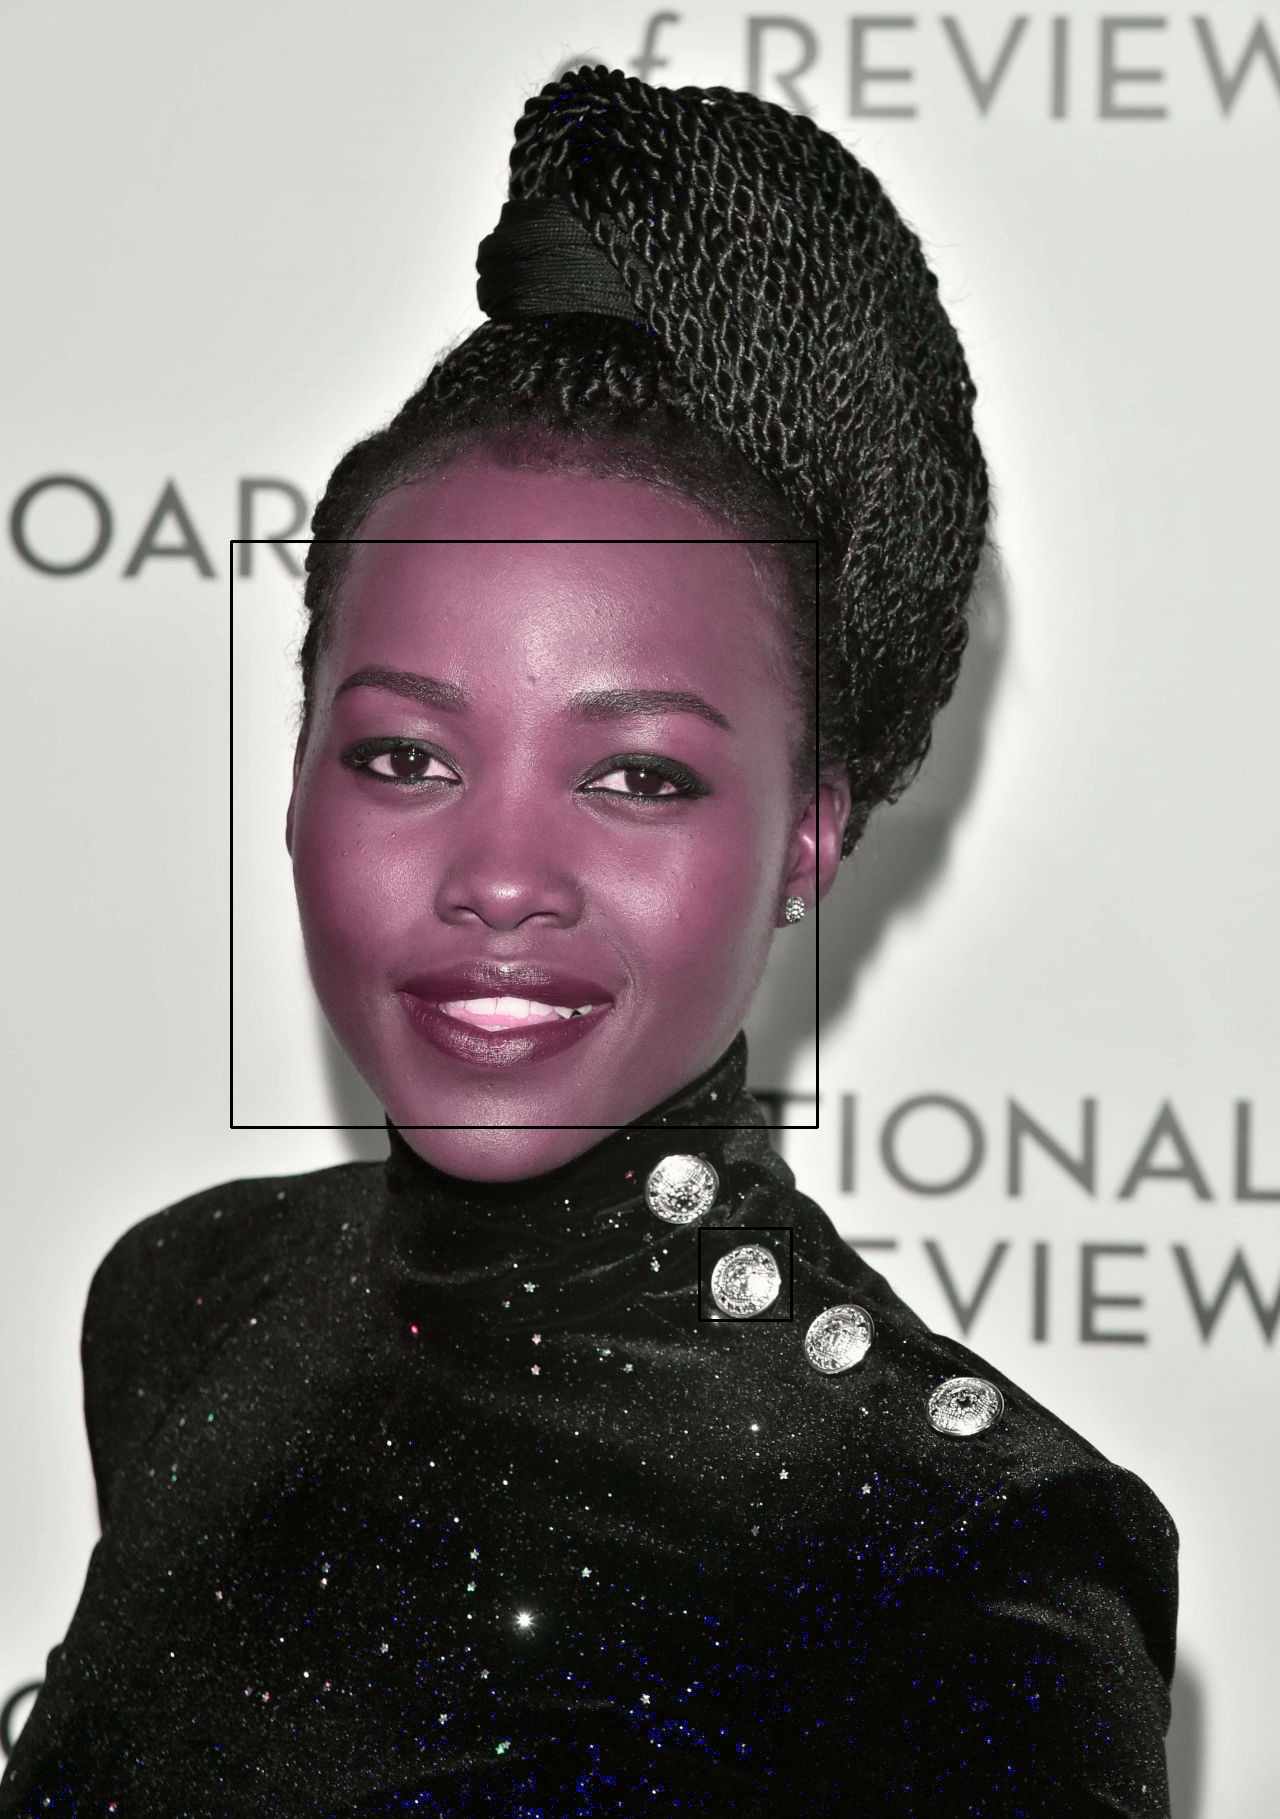

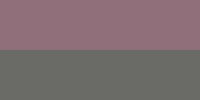

In [ ]:
import cv2
import numpy as np
import os
from sklearn.linear_model import LinearRegression
from google.colab import files
from IPython.display import Image

class SkinColorDetector:
    def __init__(self):
        self.tabela_cores = {
            "extremamente_clara": ["#FFF5EB", "#FFEDDA", "#FFE7CB", "#FFDFBB", "#FFD7AB", "#ffe0c0","#FFF8F0", "#ffe0c0", "#ffe8d0", "#FFF7F0", "#ffe8d9", "#ffdcc9", "#ffcfb9", "#ffe9e1", "#fdf4ec", "#fff4e9","#fff3e8", "#fff9f3", "#fffaf4", "#fdf6ef", "#f8f1e9", "#ffeede", "#fff2e5", "#fff7ef", "#fff8ef", "#fff0ef", "fff7df", "#fff9e6", "#f8f3e4", "#fffcf2"],
            "clara": ["#FFCDA0","#ffe8d2","#ffdbac","#ffe2bc","#f8e3c7","#ffdfb4","#f7dcb8","#f4dfc3","#f7e1c4", "#f0ddc3","#ffdfb5", "#ffdfb6","#FFC18F", "#FFB57F", "#EACBA8", "#f8f2dd"],
            "morena_clara": ["#DEB887", "#D2B48C", "#BC8F8F"],
            "media": ["#AC8B64", "#CF9E7C", "#b37e66"],
            "morena_escura": ["#A0522D", "#94613C", "#AE703A", "#92745f"],
            "escura": ["#8B4513", "#B26A49", "#a05f41", "#8d5524"],
            "muito_escura": ["#994D44", "#623A18", "#503431", "#7a3d36"],
            "negra": ["#000000", "#3F281B", "#3d1e1b"],
        }
        self.links_produtos_pele = {
            "extremamente_clara": ["https://www.boticario.com.br/base-liquida-cor-100-make-b-mate-salicylic-30g/",
                                   "https://www.belezanaweb.com.br/maybelline-superstay-active-wear-30h-110-porcelain-base-liquida-30ml/",
                                   "https://www.boticario.com.br/base-liquida-cor-120-make-b-mate-salicylic-30g/"],

            "clara": ["https://contem1g.com.br/products/base-velvet-segunda-pele?variant=44151440965851",
                      "https://www.eudora.com.br/base-liquida-glam-skin-control-cor-45-30ml/?gad_source=1&gclid=CjwKCAjwgpCzBhBhEiwAOSQWQdfgulfK8YvSJCTZnOeanuMhOy1n837ARV15ld2x_wYAotTfx6Qe_RoCEoIQAvD_BwE&gclsrc=aw.ds",
                      "https://www.boticario.com.br/base-liquida-cor-170-make-b-mate-salicylic-30g/"],

            "morena_clara": ["https://contem1g.com.br/products/base-velvet-segunda-pele?variant=44151441064155",
                             "https://www.boticario.com.br/base-liquida-cor-210-make-b-mate-salicylic-30g/",
                             "https://www.belezanaweb.com.br/vult-nano-hd-cor-v230-base-liquida-26ml/"],

            "media": ["https://contem1g.com.br/products/base-velvet-segunda-pele?variant=44151441195227",
                      "https://www.belezanaweb.com.br/vult-nano-hd-cor-v260-base-liquida-26ml/",
                      "https://www.boticario.com.br/base-liquida-cor-260-make-b-mate-salicylic-30g/"],

            "morena_escura": ["https://contem1g.com.br/products/base-velvet-segunda-pele?variant=44151441359067",
                              "https://www.boticario.com.br/base-liquida-make-b-glycolic-tx-cor-270-30g/",
                              "https://www.belezanaweb.com.br/divspan-stylecolor-inherit-fontfamily-inherit-fontsize-15remvult-nano-hd-cor-v280-base-liquida-26mlspandiv/"],

            "escura": ["https://contem1g.com.br/products/base-velvet-segunda-pele?variant=44151441457371",
                       "https://www.boticario.com.br/base-liquida-cor-310-make-b-mate-salicylic-30g/"],

            "muito_escura": ["https://www.belezanaweb.com.br/vult-nano-hd-cor-v350-base-liquida-26ml/",
                             "https://contem1g.com.br/products/base-velvet-segunda-pele?variant=44151441588443",
                             "https://contem1g.com.br/products/base-velvet-segunda-pele?variant=44151441621211"],

            "negra": ["https://www.boticario.com.br/base-liquida-cor-330-make-b-mate-salicylic-30g/",
                      "https://contem1g.com.br/products/base-velvet-segunda-pele?variant=44151441653979",
                      "https://contem1g.com.br/products/base-velvet-segunda-pele?variant=44151441785051"]
        }

    def diferenca_cor(self, cor1, cor2):
        r1, g1, b1 = int(cor1[1:3], 16), int(cor1[3:5], 16), int(cor1[5:], 16)
        r2, g2, b2 = int(cor2[1:3], 16), int(cor2[3:5], 16), int(cor2[5:], 16)
        return ((r1 - r2) ** 2 + (g1 - g2) ** 2 + (b1 - b2) ** 2) ** 0.5

    def tabela(self, cor_Hex):
        cor_mais_proxima = None
        menor_diferenca = float('inf')
        tipo_cor = None

        for categoria, cores in self.tabela_cores.items():
            for cor in cores:
                diferenca = self.diferenca_cor(cor_Hex, cor)
                if diferenca < menor_diferenca:
                    cor_mais_proxima = cor
                    menor_diferenca = diferenca
                    tipo_cor = categoria

        return tipo_cor if tipo_cor else cor_mais_proxima

    def detectar_cor_pele(self, imagem_path):
        image = self.carregar_imagem(imagem_path)
        image = self.balanco_branco(image)
        faces = self.detectar_faces(image)
        mean_skin_colors = self.calcular_cores_medias(image, faces)
        self.desenhar_retangulos(image, faces)
        mean_color = mean_skin_colors[0]
        mean_color_hex = self.rgb_para_hex(mean_color)
        tipo_cor_pele = self.tabela(mean_color_hex)

        self.criar_pasta(tipo_cor_pele)
        self.salvar_imagem(image, f'{tipo_cor_pele}/output_segmented.jpg')
        mean_skin_colors_image = self.criar_imagem_cores_medias(mean_skin_colors)
        self.salvar_imagem(mean_skin_colors_image, f'{tipo_cor_pele}/mean_skin_colors.jpg')
        self.salvar_texto(mean_color_hex, f'{tipo_cor_pele}/mean_color_hex.txt')

        link_produto_pele = self.links_produtos_pele.get(tipo_cor_pele)

        return mean_color_hex, tipo_cor_pele, link_produto_pele

    def carregar_imagem(self, imagem_path):
        return cv2.imread(imagem_path)

    def detectar_faces(self, image):
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
        faces = face_cascade.detectMultiScale(gray_image, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
        return faces

    def calcular_cores_medias(self, image, faces):
        mean_skin_colors = []
        for (x, y, w, h) in faces:
            face_roi = image[y:y+h, x:x+w]
            mean_color = cv2.mean(face_roi)[:3]
            mean_skin_colors.append(mean_color)
        return mean_skin_colors

    def desenhar_retangulos(self, image, faces):
        for (x, y, w, h) in faces:
            cv2.rectangle(image, (x, y), (x+w, y+h), (0, 0, 0), 2)

    def salvar_imagem(self, image, path):
        cv2.imwrite(path, image)

    def criar_imagem_cores_medias(self, mean_skin_colors):
        height = len(mean_skin_colors) * 50
        mean_skin_colors_image = np.zeros((height, 200, 3), dtype=np.uint8)
        for i, color in enumerate(mean_skin_colors):
            mean_skin_colors_image[i*50:i*50+50, :] = color
        return mean_skin_colors_image

    def rgb_para_hex(self, rgb):
        return '#{:02x}{:02x}{:02x}'.format(int(rgb[2]), int(rgb[1]), int(rgb[0]))

    def criar_pasta(self, pasta):
        if not os.path.exists(pasta):
            os.makedirs(pasta)

    def salvar_texto(self, texto, path):
        with open(path, 'w') as f:
            f.write(texto)

    def balanco_branco(self, original_image):
        original_image_float = original_image.astype(np.float32)
        red_channel = original_image_float[:, :, 2].ravel()
        green_channel = original_image_float[:, :, 1].ravel()
        blue_channel = original_image_float[:, :, 0].ravel()

        X = np.stack([red_channel, green_channel], axis=1)
        regressor = LinearRegression()
        regressor.fit(X, blue_channel.reshape(-1, 1))

        predicted_blue_channel = regressor.predict(X).reshape(original_image.shape[:2])
        balanced_image = original_image.copy()
        balanced_image[:, :, 0] = predicted_blue_channel

        return np.clip(balanced_image, 0, 255).astype(np.uint8)

detector = SkinColorDetector()
uploaded = files.upload()
for filename in uploaded.keys():
    mean_color_hex, tipo_cor_pele, link_produto_pele = detector.detectar_cor_pele(filename)
    print(f"Cor Média (Hex): {mean_color_hex}")
    print(f"Tipo de Cor da Pele: {tipo_cor_pele}")
    print(f"Links de Produtos Recomendados: {link_produto_pele}")
    display(Image(filename=f'{tipo_cor_pele}/output_segmented.jpg'))
    display(Image(filename=f'{tipo_cor_pele}/mean_skin_colors.jpg'))